In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import json
import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd
from torch_geometric.loader import ShaDowKHopSampler, NeighborLoader
from torch_geometric.utils import k_hop_subgraph

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.arxiv import load_data, get_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.gamma import GammaGraphSage

In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

In [6]:
depth = 1
k = 50
out_path = f'data/graph_modifications/02-1-k{k}_best_edges.csv'

## Data Loading

In [7]:
data = load_data()
data = prepare_adjencency(data, to_symmetric=True).to(device)

In [8]:
data.adj_t.sum(dim=1).max()

tensor(13161., device='cuda:0')

## Load $\Gamma$ function

In [9]:
best_model_metrics = json.load(open('models/gamma_graph_sage/best_model_info.json'))

### Load model

In [10]:
gamma = GammaGraphSage.load_model(
    int(best_model_metrics['run']),
    int(best_model_metrics['epoch']),
    device,
    data.num_nodes)

## Rewire graph

In [11]:
row, col, edge_attr = data.adj_t.t().coo()
edge_index = torch.stack([row, col], dim=0).to(data.adj_t.device())

In [12]:
def get_node_k_highest_gamma_edges(node, k, depth, edge_index, data):
    khop_nodes, _, _, _ = k_hop_subgraph(node, depth, edge_index)
    target = khop_nodes[khop_nodes != node]
    source = torch.tensor([node] * target.size()[0]).to(data.adj_t.device())
    
    gamma_preds = gamma.forward(
        torch.stack([source, target]).to(data.adj_t.device()),
        data.adj_t).detach()
    
    node_neighborhood = torch.stack([
        source,
        target,
        gamma_preds.squeeze(dim=1)
    ])
    
    sorted_indices = node_neighborhood[2,:].sort(descending=True)[1]
    
    sorted_neighborhood = node_neighborhood[:, sorted_indices]
    
    n_edges = min(k, sorted_neighborhood.size(1))
    
    return sorted_neighborhood[:, :n_edges]
        

In [13]:
node_edges_dict = {}
for node in range(data.num_nodes):
    if node % 10000 == 0:
        print(f'{node + 1}/{data.num_nodes}')
    node_edges_dict[node] = get_node_k_highest_gamma_edges(
            node,
            k,
            depth,
            edge_index,
            data)\
        .detach()\
        .cpu()\
        .numpy()

1/169343
10001/169343
20001/169343
30001/169343
40001/169343
50001/169343
60001/169343
70001/169343
80001/169343
90001/169343
100001/169343
110001/169343
120001/169343
130001/169343
140001/169343
150001/169343
160001/169343


## Save output

In [14]:
for it, edges_info in enumerate(node_edges_dict.values()):
    edges_df = pd.DataFrame(
        edges_info.T.tolist(),
        columns=['source', 'target', 'weight'])
    
    if it == 0:
        edges_df.to_csv(out_path, index=False)
    else:
        edges_df.to_csv(out_path, mode='a', header=False, index=False)

## Statistics

In [15]:
edges_df = pd.read_csv(out_path)
print(edges_df.shape)
edges_df.head()

(1833170, 3)


,source,target,weight
0,0.0,161310.0,0.790365
1,0.0,113080.0,0.790083
2,0.0,139581.0,0.790068
3,0.0,21760.0,0.789761
4,0.0,10839.0,0.789665


### Number of neighbors for each node

In [16]:
edges_df.groupby('source')\
    ['target']\
    .count()\
    .describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.15])

count    169343.000000
mean         10.825189
std          11.853353
min           1.000000
1%            1.000000
2.5%          1.000000
5%            1.000000
10%           1.000000
15%           2.000000
50%           6.000000
max          50.000000
Name: target, dtype: float64

In [17]:
edges_df.groupby('source')\
    ['weight']\
    .mean()\
    .describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.15])

count    169343.000000
mean          0.746161
std           0.040491
min           0.179753
1%            0.597941
2.5%          0.636711
5%            0.665462
10%           0.694090
15%           0.710534
50%           0.758221
max           0.790425
Name: weight, dtype: float64

In [18]:
edges_df.groupby('source')\
    ['weight']\
    .median()\
    .describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.15])

count    169343.000000
mean          0.754544
std           0.039317
min           0.179753
1%            0.598716
2.5%          0.642632
5%            0.675819
10%           0.706741
15%           0.723408
50%           0.767649
max           0.790529
Name: weight, dtype: float64

## Calculate $\Theta$ of the new graph

In [19]:
graph_theta = gamma.is_same_class(edge_index, data.y).float().mean().item()
graph_theta

0.6542198061943054

In [20]:
edges_df['rank'] = edges_df\
    .groupby('source')\
    ['weight']\
    .rank(ascending=False, method='first')
edges_df.head()

,source,target,weight,rank
0,0.0,161310.0,0.790365,1.0
1,0.0,113080.0,0.790083,2.0
2,0.0,139581.0,0.790068,3.0
3,0.0,21760.0,0.789761,4.0
4,0.0,10839.0,0.789665,5.0


In [21]:
edges_df.shape

(1833170, 4)

In [22]:
thetas = {}
for sub_k in range(1, k + 1):
    k_edges_df = edges_df.query(f'rank <= {sub_k}')
    
    edges = k_edges_df[['source', 'target']].astype(int).values.T
    thetas[sub_k] = gamma.is_same_class(edges, data.y).float().mean().item()

In [23]:
k_best_thetas = pd.DataFrame.from_dict(thetas, orient='index', columns=['theta'])
k_best_thetas.head()

,theta
1,0.685538
2,0.685078
3,0.684755
4,0.683910
5,0.682940


Text(0, 0.5, '$\\Theta$')

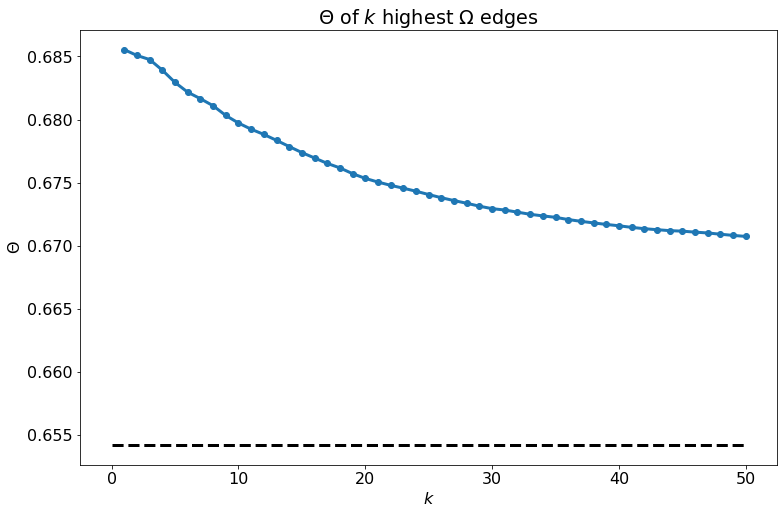

In [24]:
plt.figure(figsize=(12.5, 8))
plt.rcParams.update({'font.size': 16})
plt.title('$\Theta$ of $k$ highest $\Omega$ edges')
plt.plot(k_best_thetas, lw=3, marker='o')
plt.hlines(graph_theta, 0, k, ls='--', color='black', lw=3)
plt.xlabel('$k$')
plt.ylabel('$\Theta$')